<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/01_Intro_to_Time_Series_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Doug Williams (https://github.com/williamsdoug) and Ignacio Oguiza (https://github.com/timeseriesAI/tsai). 

contact: timeseriesAI@gmail.com

## Purpose 😇

The purpose of this notebook is to demonstrate both multi-class and multi-label classification using `tsai`. 

- Multi-class classification: While the output can take on multiple possible values, for any given sample the output can take on only a single value. In other words, the label values are mutually exclusive. Implication:
 - CategoricalCrossEntropy (`nn.CrossEntropyLoss` in Pytorch, `CrossEntropyLossFlat` in fastai) is used as the loss function during training
 - Softmax is used to determine prediction since only one label value can be true, the predicted label is the value label value with the greatest probability. 
 - Softmax reduces the potential for spurious label predictions since only the label with the highest probability is selected
 - In both Pytorch and fastai the loss combines a Softmax layer and the CrossEntropyLoss in one single class, so Softmax shouldn't be added to the model.
 
- Multi-label classification: This is the more general case where an individual sample can have one or more labels, relaxing the mutual label exclusivity constraint. Implications:
 - BinaryCrossEntropy (`nn.BCEWithLogitsLoss` in Pytorch, `BCEWithLogitsLossFlat` in fastai) is used as the loss function during training
 - Sigmoid is used to determine prediction since multiple labels may be true. In both Pytorch and fastai the loss combines a Sigmoid layer and the BCELoss in one single class, so Sigmoid shouldn't be added to the model.
 - Relative to multi-class classification, multi-label classification may be more prone to spurious false-positive labels.

## Import libraries 📚

In [ ]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [ ]:
from tsai.all import *
computer_setup()

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.0+cu101


## Prepare data 🔢

For this example we will be using the UCR ECG5000 heartbeat dataset with is based on the [Physionet BIDMC Congestive Heart Failure Database](https://physionet.org/content/chfdb/1.0.0/]), specifically recording chf07.

For the purposes of this example the UCR labels will be mapped to more descriptive labels:

- 1 - Normal ('Nor')
- 2 - R-on-T premature ventricular contraction ('RoT')
- 3 - Premature ventricular contraction ('PVC')
- 4 - Supraventricular premature or ectopic beat, atrial or nodal ('SPC')
- 5 - Unclassifiable beat ('Unk')

In [ ]:
class_map = {
    '1':'Nor',  # N:1  - Normal
    '2':'RoT',  # r:2  - R-on-T premature ventricular contraction
    '3':'PVC',  # V:3  - Premature ventricular contraction
    '4':'SPC',  # S:4  - Supraventricular premature or ectopic beat (atrial or nodal)
    '5':'Unk',  # Q:5  - Unclassifiable beat
    }
class_map

{'1': 'Nor', '2': 'RoT', '3': 'PVC', '4': 'SPC', '5': 'Unk'}

In [ ]:
# dataset id
dsid = 'ECG5000' 
X, y, splits = get_UCR_data(dsid, split_data=False)
labeler = ReLabeler(class_map)
new_y = labeler(y) # map to more descriptive labels
X.shape, new_y.shape, splits, new_y

((5000, 1, 140),
 (5000,),
 ((#500) [0,1,2,3,4,5,6,7,8,9...],
  (#4500) [500,501,502,503,504,505,506,507,508,509...]),
 array(['Nor', 'Nor', 'Nor', ..., 'RoT', 'RoT', 'RoT'], dtype='<U3'))

In [ ]:
label_counts = collections.Counter(new_y)
print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

Counts by label: {'Nor': 2919, 'RoT': 1767, 'PVC': 96, 'SPC': 194, 'Unk': 24}
Naive Accuracy: 58.38%


Note: naive accuracy is calculated by assuming all samples are predicted as 'Nor' (most frequent label).

## Multi-class classification

### Prepare dataloaders 💿

In [ ]:
tfms  = [None, TSClassification()] # TSClassification == Categorize
batch_tfms = TSStandardize()
dls = get_ts_dls(X, new_y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls.dataset

(#500) [(TSTensor(vars:1, len:140), TensorCategory(0)),(TSTensor(vars:1, len:140), TensorCategory(0)),(TSTensor(vars:1, len:140), TensorCategory(0)),(TSTensor(vars:1, len:140), TensorCategory(0)),(TSTensor(vars:1, len:140), TensorCategory(0)),(TSTensor(vars:1, len:140), TensorCategory(0)),(TSTensor(vars:1, len:140), TensorCategory(0)),(TSTensor(vars:1, len:140), TensorCategory(0)),(TSTensor(vars:1, len:140), TensorCategory(0)),(TSTensor(vars:1, len:140), TensorCategory(0))...]

### Visualize data

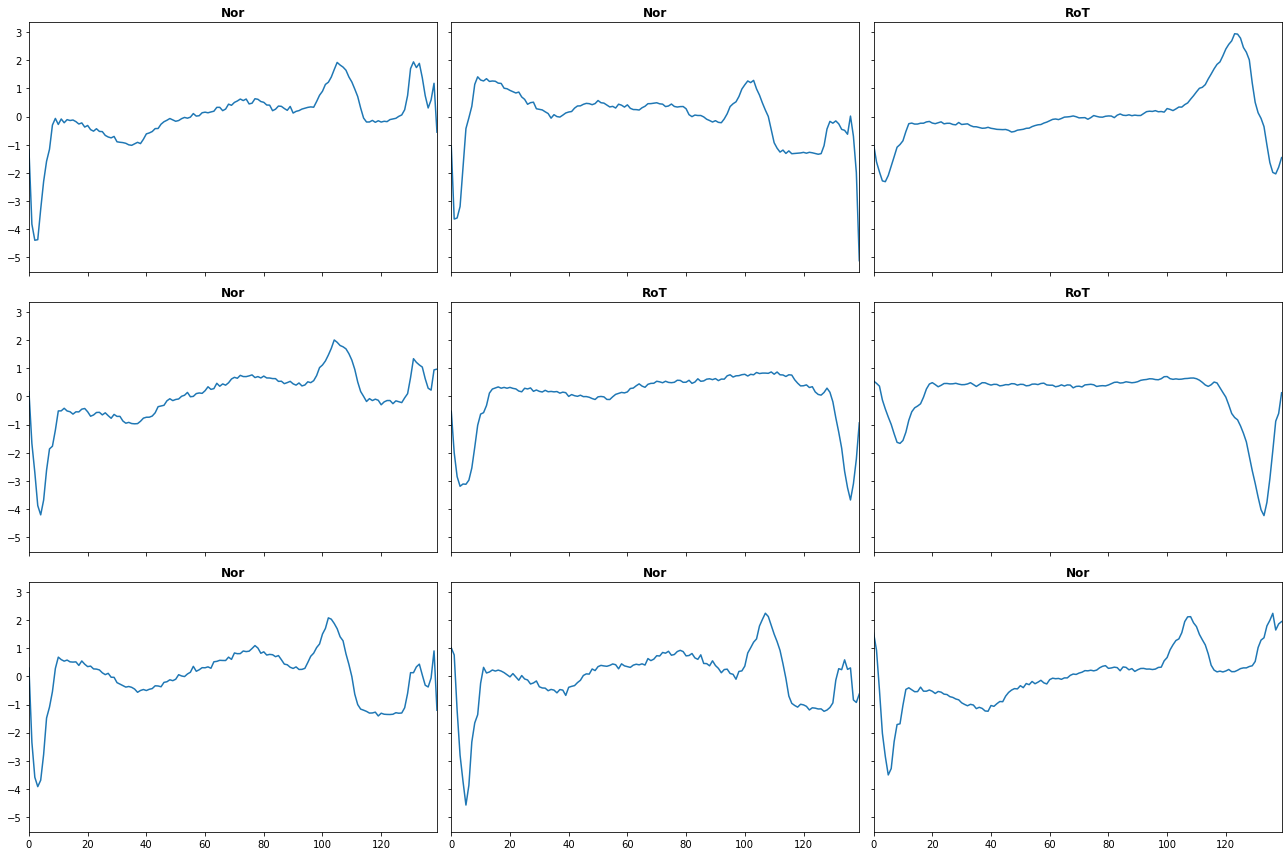

In [ ]:
dls.show_batch(sharey=True)

### Build learner 🏗

There are at least 2 equivalent ways to build a time series learner: 

In [ ]:
model = build_ts_model(InceptionTimePlus, dls=dls)
learn = Learner(dls, model, metrics=accuracy)

In [ ]:
learn = ts_learner(dls, metrics=accuracy) # == ts_learner(dls, arch=InceptionTimePlus, metrics=accuracy) since InceptionTimePlus is the default arch

### LR find 🔎

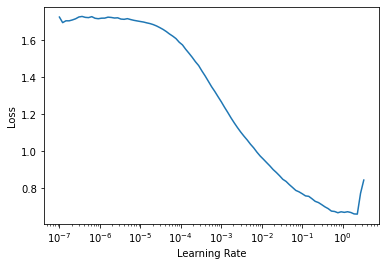

In [ ]:
learn.lr_find(suggestions=False)

### Train 🏃🏽‍♀️

epoch,train_loss,valid_loss,accuracy,time
0,1.264956,1.545940,0.581778,00:00
1,0.887806,1.385914,0.824444,00:00
2,0.673900,0.781568,0.908667,00:00
3,0.547284,0.305173,0.929111,00:00
4,0.462423,0.303337,0.923111,00:00
5,0.399307,0.253951,0.933111,00:00
6,0.351241,0.324293,0.929111,00:00
7,0.315202,0.253938,0.943778,00:00
8,0.286147,0.226004,0.944444,00:00
9,0.262180,0.220572,0.944889,00:00


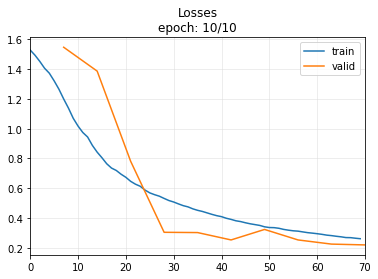

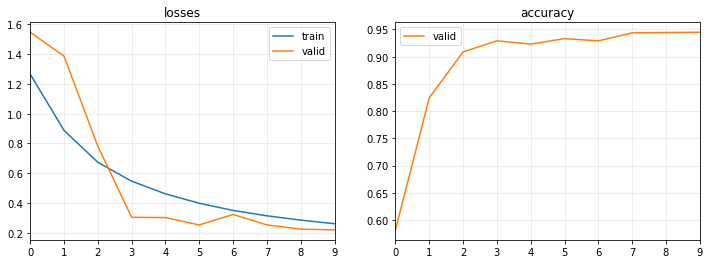

In [ ]:
learn = ts_learner(dls, metrics=accuracy, cbs=ShowGraph())
learn.fit_one_cycle(10, lr_max=1e-3)

Now that the model is trained, we'll save it to create predictions in the future: 

In [ ]:
PATH = Path('./models/Multiclass.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

### Visualize results 👁

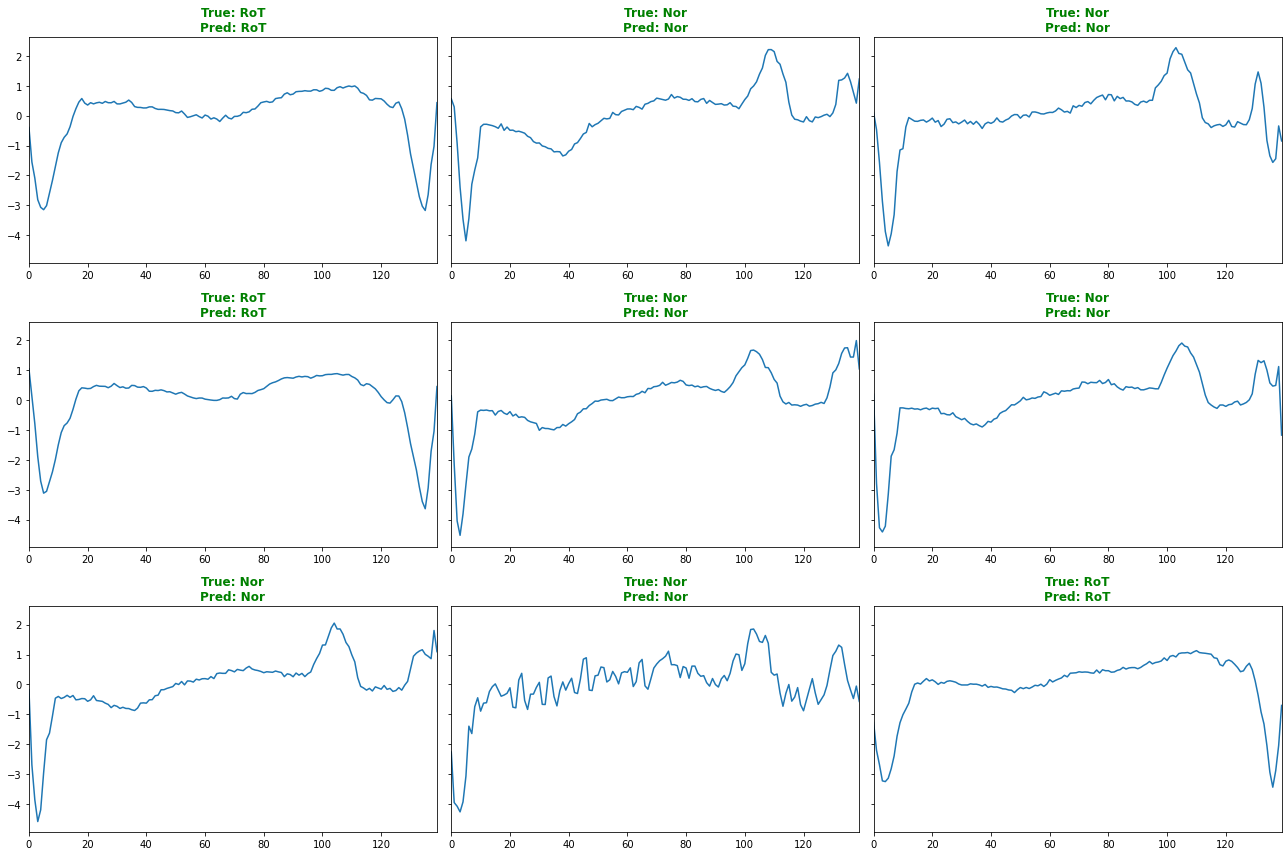

In [ ]:
learn.show_results(sharey=True)

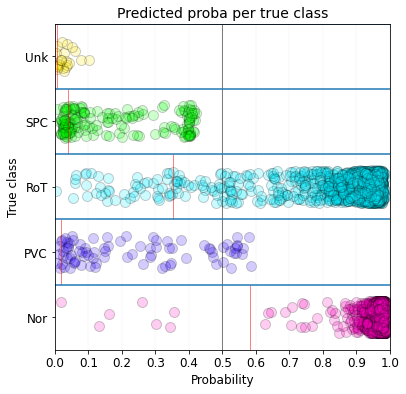

In [ ]:
learn.show_probas()

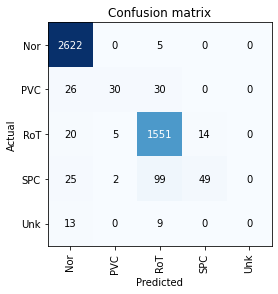

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=3)

[('SPC', 'RoT', 99),
 ('PVC', 'RoT', 30),
 ('PVC', 'Nor', 26),
 ('SPC', 'Nor', 25),
 ('RoT', 'Nor', 20),
 ('RoT', 'SPC', 14),
 ('Unk', 'Nor', 13),
 ('Unk', 'RoT', 9),
 ('Nor', 'RoT', 5),
 ('RoT', 'PVC', 5)]

### Create predictions 🌦

To get predictions we need to create a learner object from the saved file: 

In [ ]:
PATH = Path('./models/Multiclass.pkl')
learn_gpu = load_learner(PATH, cpu=False)

We can now generate predictions using just the X as input. This can be done with a 'gpu' or a 'cpu'. And for many samples, or just one at a time: 

In [ ]:
# gpu, many samples
probas, _, preds = learn_gpu.get_X_preds(X[splits[1]])
preds[-10:]

(#10) ['RoT','RoT','RoT','SPC','SPC','RoT','SPC','RoT','RoT','SPC']

In [ ]:
skm.accuracy_score(new_y[splits[1]], preds)

0.9448888888888889

In [ ]:
PATH = Path('./models/Multiclass.pkl')
learn_cpu = load_learner(PATH, cpu=True)

In [ ]:
# cpu, single sample
probas, _, preds = learn_cpu.get_X_preds(X[-1])
preds

(#1) ['SPC']

## Multi-label Classification

### Augment labels to demonstrate multi-label

- Create additional label premature ('Pre')
- Include with any sample where labels 'RoT','PVC','SPC' are already present


Note:  While in this example the new Pre label is a composite of existing labels, more typically multi-label classification problems include orthogonal label groups.  For example in ECG classification one might have labels related to timing (e.g.: premature), QRS shape (e.g.: block) and other factors (e.g.: ST elevation or depression)

In [ ]:
class_map = {
    '1':['Nor'],          # N:1  - Normal
    '2':['RoT', 'Pre'],   # r:2  - R-on-T premature ventricular contraction
    '3':['PVC', 'Pre'] ,  # V:3  - Premature ventricular contraction
    '4':['SPC', 'Pre'],   # S:4  - Supraventricular premature or ectopic beat (atrial or nodal)
    '5':['Unk'],          # Q:5  - Unclassifiable beat
    }
class_map

{'1': ['Nor'],
 '2': ['RoT', 'Pre'],
 '3': ['PVC', 'Pre'],
 '4': ['SPC', 'Pre'],
 '5': ['Unk']}

In [ ]:
labeler = ReLabeler(class_map)
y_multi = labeler(y)
y_multi

array([list(['Nor']), list(['Nor']), list(['Nor']), ...,
       list(['RoT', 'Pre']), list(['RoT', 'Pre']), list(['RoT', 'Pre'])],
      dtype=object)

In [ ]:
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'Nor': 2919, 'RoT': 1767, 'Pre': 2057, 'PVC': 96, 'SPC': 194, 'Unk': 24}


### Prepare Dataloaders

- Replace earlier ```tfms  = [None, [TSClassification()]]```  with ```tfms  = [None, TSMultiLabelClassification()]```
- TSMultiLabelClassification() is equivalent to [MultiCategorize(), OneHotEncode()] combined in a single transform.
- When creating dataloaders in multi-label problems, always leave inplace=True (default value) to avoid issues.

In [ ]:
tfms  = [None, TSMultiLabelClassification()] # TSMultiLabelClassification() == [MultiCategorize(), OneHotEncode()]
batch_tfms = TSStandardize()
dls = get_ts_dls(X, y_multi, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls.dataset

(#500) [(TSTensor(vars:1, len:140), TensorMultiCategory([1., 0., 0., 0., 0., 0.])),(TSTensor(vars:1, len:140), TensorMultiCategory([1., 0., 0., 0., 0., 0.])),(TSTensor(vars:1, len:140), TensorMultiCategory([1., 0., 0., 0., 0., 0.])),(TSTensor(vars:1, len:140), TensorMultiCategory([1., 0., 0., 0., 0., 0.])),(TSTensor(vars:1, len:140), TensorMultiCategory([1., 0., 0., 0., 0., 0.])),(TSTensor(vars:1, len:140), TensorMultiCategory([1., 0., 0., 0., 0., 0.])),(TSTensor(vars:1, len:140), TensorMultiCategory([1., 0., 0., 0., 0., 0.])),(TSTensor(vars:1, len:140), TensorMultiCategory([1., 0., 0., 0., 0., 0.])),(TSTensor(vars:1, len:140), TensorMultiCategory([1., 0., 0., 0., 0., 0.])),(TSTensor(vars:1, len:140), TensorMultiCategory([1., 0., 0., 0., 0., 0.]))...]

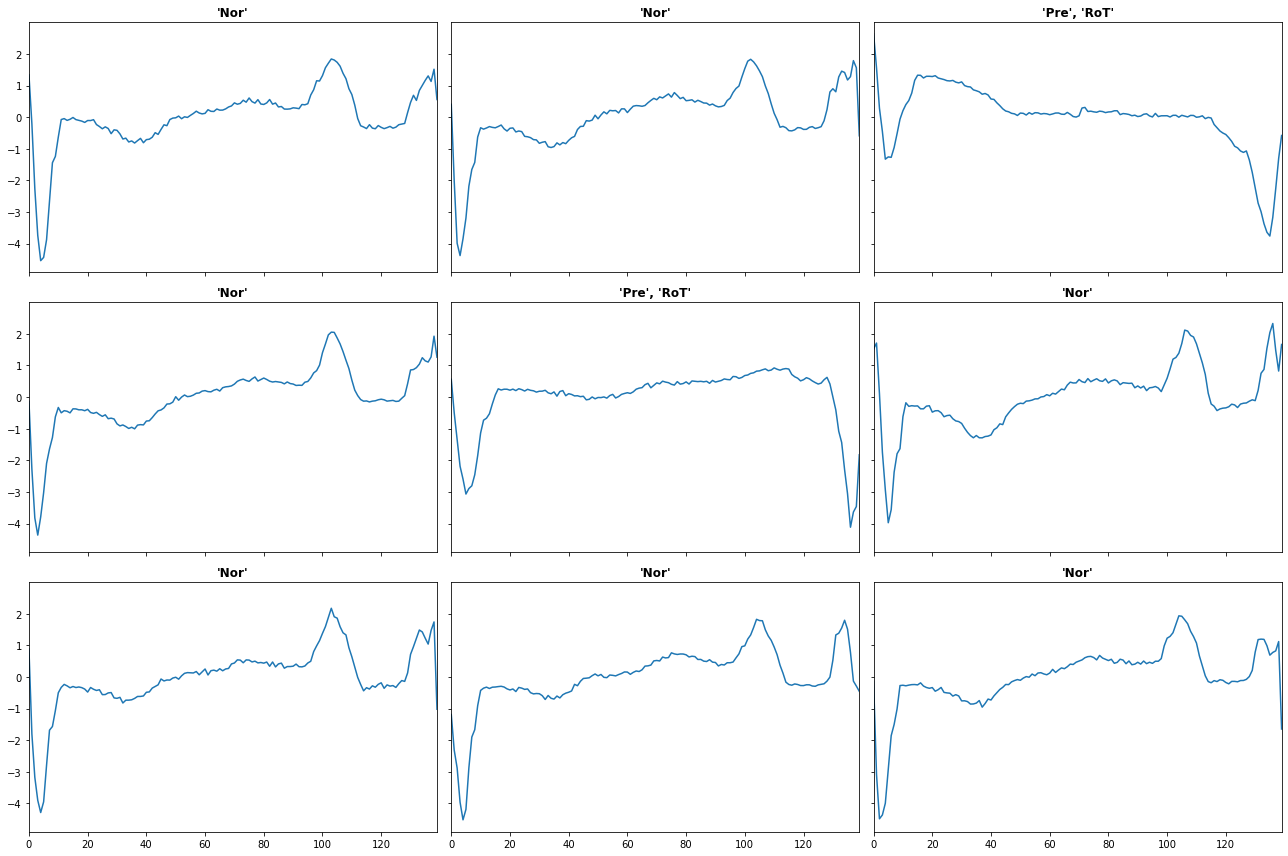

In [ ]:
dls.show_batch(sharey=True)

### Build Learner and Train

- Use ```metrics=accuracy_multi``` in place of ```metrics=accuracy``` used in earlier multi-class example

- accuracy_multi can be calculated by sample (default) or by predicted label. When using accuracy_multi by_sample=True, all predicted labels for each sample must be correct to be counted as a correct sample. This is sometimes difficult (when having too many labels). There are cases when labels are partially correct. If we want to account for these, we'll set by_sample to False. 

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True, by_sample=False):
    "Computes accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    correct = (inp>thresh)==targ.bool()
    if by_sample:
        return (correct.float().mean(-1) == 1).float().mean()
    else:
        inp,targ = flatten_check(inp,targ)
        return correct.float().mean()

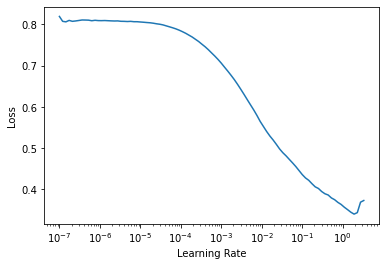

In [ ]:
learn = ts_learner(dls, InceptionTime, metrics=accuracy_multi)
learn.lr_find(suggestions=False)

epoch,train_loss,valid_loss,accuracy_multi,accuracy_multi,time
0,0.640195,0.693988,0.000000,0.430889,00:00
1,0.525969,0.640191,0.352222,0.783296,00:00
2,0.429255,0.423845,0.880889,0.955630,00:00
3,0.353816,0.223852,0.927333,0.973259,00:00
4,0.299557,0.150758,0.927556,0.973630,00:00
5,0.257449,0.110211,0.924889,0.973741,00:00
6,0.224938,0.114506,0.928444,0.975111,00:00
7,0.199530,0.109768,0.929333,0.975000,00:00
8,0.179275,0.107410,0.928444,0.975111,00:00
9,0.163472,0.104250,0.928000,0.975334,00:00


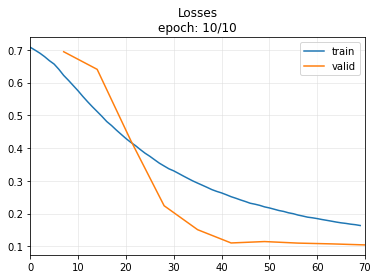

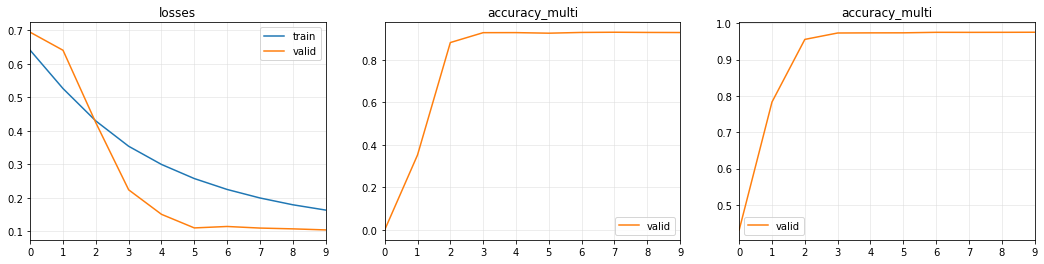

In [ ]:
learn = ts_learner(dls, InceptionTimePlus, metrics=[partial(accuracy_multi, by_sample=True), partial(accuracy_multi, by_sample=False)], cbs=ShowGraph())
learn.fit_one_cycle(10, lr_max=1e-3)

### Additional Multi-label Metrics

A naive classifier that always predicts no true labels would achieve 76% accuracy, so the classifier should do much better.  This also demonstrates the weakness of relying overly on the accuracy metric (with by_sample=False) since due to the prevalance of false outputs.

In [ ]:
label_counts = collections.Counter([a for r in y_multi for a in r])
print(f'Naive Accuracy: {100*(1-sum(label_counts.values())/(len(y_multi)*len(label_counts))):0.2f}%')

Naive Accuracy: 76.48%


### Define Metrics

We have included a number of multilabel metrics in `tsai` based on definitions in [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall#F-measure)

In [ ]:
def precision_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Computes precision when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TP = torch.logical_and(correct,  (targ==1).bool()).sum()
    FP = torch.logical_and(~correct, (targ==0).bool()).sum()

    precision = TP/(TP+FP)
    return precision

def recall_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Computes recall when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TP = torch.logical_and(correct,  (targ==1).bool()).sum()
    FN = torch.logical_and(~correct, (targ==1).bool()).sum()

    recall = TP/(TP+FN)
    return recall

def specificity_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Computes specificity (true negative rate) when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TN = torch.logical_and(correct,  (targ==0).bool()).sum()
    FP = torch.logical_and(~correct, (targ==0).bool()).sum()

    specificity = TN/(TN+FP)
    return specificity

def balanced_accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Computes balanced accuracy when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TP = torch.logical_and(correct,  (targ==1).bool()).sum()
    TN = torch.logical_and(correct,  (targ==0).bool()).sum()
    FN = torch.logical_and(~correct, (targ==1).bool()).sum()
    FP = torch.logical_and(~correct, (targ==0).bool()).sum()

    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    balanced_accuracy = (TPR+TNR)/2
    return balanced_accuracy

def Fbeta_multi(inp, targ, beta=1.0, thresh=0.5, sigmoid=True):
    "Computes Fbeta when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TP = torch.logical_and(correct,  (targ==1).bool()).sum()
    TN = torch.logical_and(correct,  (targ==0).bool()).sum()
    FN = torch.logical_and(~correct, (targ==1).bool()).sum()
    FP = torch.logical_and(~correct, (targ==0).bool()).sum()

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    beta2 = beta*beta
    
    if precision+recall > 0:
        Fbeta = (1+beta2)*precision*recall/(beta2*precision+recall)
    else:
        Fbeta = 0
    return Fbeta

def F1_multi(*args, **kwargs):
    return Fbeta_multi(*args, **kwargs)  # beta defaults to 1.0

### Train Classifier Including More Metrics

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.645099,0.686013,0.639889,0.688714,0.358783,0.752212,0.625217,0.478856,00:00
1,0.554594,0.653687,0.730556,0.800884,0.464848,0.944597,0.657170,0.622563,00:00
2,0.460343,0.510035,0.960148,0.952828,0.897912,0.936945,0.968710,0.916550,00:00
3,0.382967,0.311899,0.968926,0.961619,0.936728,0.945415,0.977823,0.940945,00:00
4,0.322325,0.171814,0.974037,0.967752,0.967828,0.949874,0.985630,0.958411,00:00
5,0.277157,0.117517,0.974407,0.969582,0.963527,0.955908,0.983257,0.959632,00:00
6,0.241605,0.128857,0.975074,0.970398,0.963100,0.957536,0.983260,0.960266,00:00
7,0.213519,0.114925,0.975482,0.969800,0.967965,0.953898,0.985701,0.960668,00:00
8,0.191561,0.111307,0.975704,0.970256,0.967504,0.955023,0.985489,0.961023,00:00
9,0.174573,0.108131,0.975556,0.970094,0.967165,0.954800,0.985389,0.960757,00:00


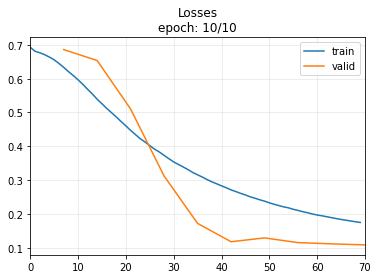

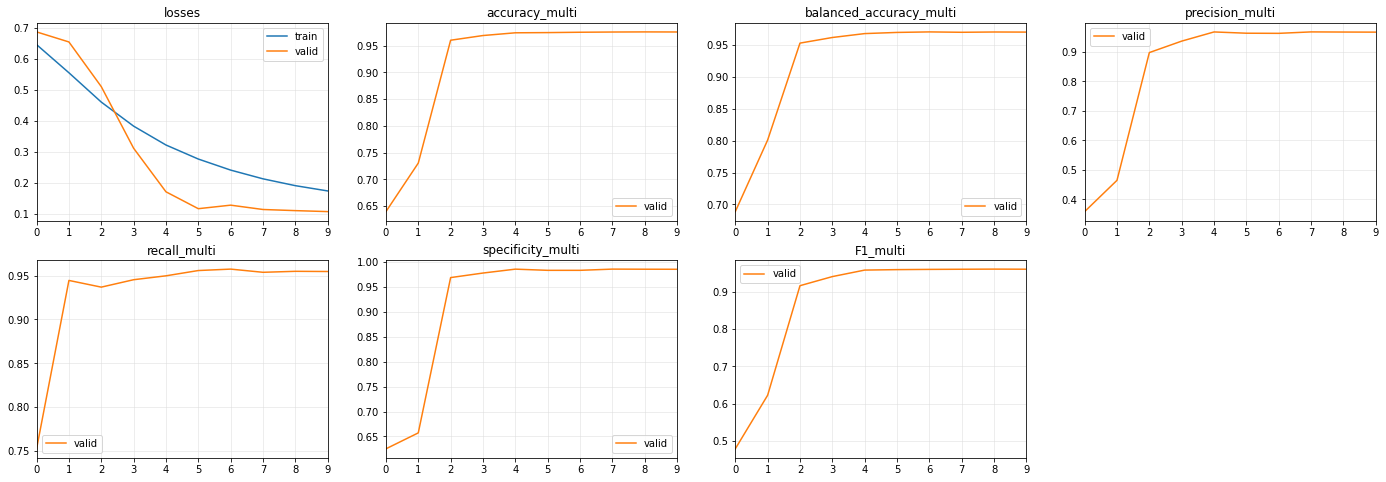

In [ ]:
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
learn = ts_learner(dls, InceptionTime, metrics=metrics, cbs=ShowGraph())
learn.fit_one_cycle(10, lr_max=1e-3)

### Optionally Use Class (Positive) Weights

- Include Per-label positive weights bias the loss function to give greater importance to samples where label is present with loss function
- `tsai` automatically calculates class weights. It's a dataloaders attribute called cws. **You should use dls.train.cws to avoid any leakage.**

### Prepare DataLoaders

In [ ]:
tfms  = [None, TSMultiLabelClassification()] # TSMultiLabelClassification() == [MultiCategorize(), OneHotEncode()]
batch_tfms = TSStandardize()
dls = get_ts_dls(X, y_multi, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls.vocab, dls.train.cws

(['Nor', 'PVC', 'Pre', 'RoT', 'SPC', 'Unk'],
 tensor([  0.7123,  49.0000,   1.4272,   1.8249,  25.3158, 249.0000],
        device='cuda:0'))

### Build Learner and Train

- Include class weights with ```loss_func```

In [ ]:
metrics = [accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi,  specificity_multi, F1_multi]
learn = ts_learner(dls, InceptionTime, metrics=metrics, loss_func=BCEWithLogitsLossFlat(pos_weight=dls.train.cws), cbs=ShowGraph())

SuggestedLRs(lr_min=0.03981071710586548, lr_steep=6.30957356406725e-06)

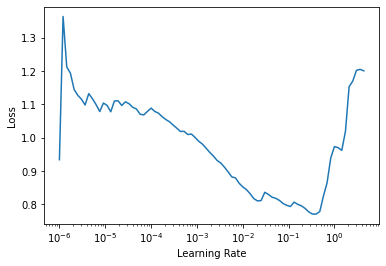

In [ ]:
learn.lr_find(suggestions=True, start_lr=1e-06, end_lr=1e2)

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,1.068970,1.081831,0.292630,0.202394,0.030968,0.048023,0.356766,0.037634,00:00
1,1.021150,1.077952,0.318778,0.220633,0.035314,0.054952,0.386314,0.042950,00:00
2,0.938508,1.052437,0.678741,0.735994,0.413841,0.860860,0.611129,0.558461,00:00
3,0.844625,0.923488,0.791148,0.839499,0.556642,0.960321,0.718676,0.702523,00:00
4,0.763067,0.753210,0.846518,0.876355,0.693905,0.964517,0.788192,0.796502,00:00
5,0.683408,0.717611,0.930741,0.940909,0.856655,0.972253,0.909564,0.905843,00:00
6,0.616204,0.967126,0.843296,0.862790,0.742360,0.919258,0.806321,0.810685,00:00
7,0.569186,1.032239,0.686074,0.728476,0.399090,0.836580,0.620372,0.539639,00:00
8,0.522062,0.705649,0.915074,0.930082,0.789405,0.971839,0.888324,0.868171,00:00
9,0.479470,1.057546,0.844556,0.889185,0.600624,0.962168,0.816203,0.725583,00:00


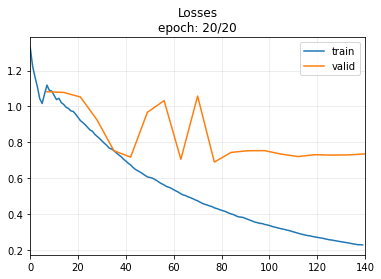

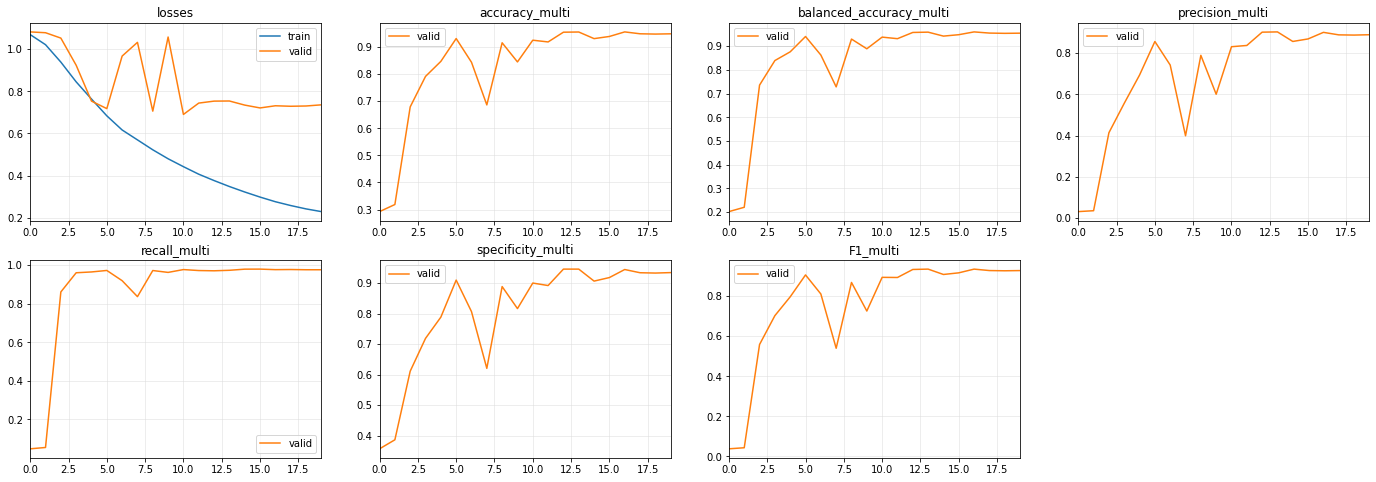

In [ ]:
learn.fit_one_cycle(20, lr_max=1e-3)

### Try Again with Reduced Weights (reduce by sqrt)

In [ ]:
metrics = [accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi,  specificity_multi, F1_multi]
learn = ts_learner(dls, InceptionTime, metrics=metrics, loss_func=BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt()), cbs=ShowGraph())

SuggestedLRs(lr_min=0.1, lr_steep=0.0022908677347004414)

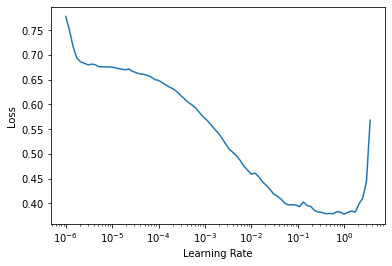

In [ ]:
learn.lr_find(suggestions=True, start_lr=1e-06, end_lr=1e2)

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.637877,0.718952,0.733852,0.542728,0.410985,0.202884,0.882572,0.271437,00:00
1,0.545982,0.686916,0.781259,0.619060,0.400822,0.363037,0.875083,0.380748,00:00
2,0.461379,0.529026,0.969111,0.960122,0.946211,0.938432,0.981812,0.941803,00:00
3,0.395855,0.275755,0.968148,0.960876,0.956429,0.940483,0.981270,0.948040,00:00
4,0.341779,0.231210,0.975519,0.971340,0.963048,0.959731,0.982950,0.961309,00:00
5,0.304022,0.210915,0.976667,0.972612,0.965552,0.961460,0.983765,0.963420,00:00
6,0.270976,0.188130,0.978333,0.974648,0.964451,0.965245,0.984051,0.964795,00:00
7,0.247522,0.177352,0.977074,0.972860,0.960765,0.962632,0.983089,0.961653,00:00
8,0.226699,0.181566,0.976185,0.972924,0.957754,0.965053,0.980795,0.961347,00:00
9,0.209531,0.181062,0.975667,0.972633,0.955817,0.965506,0.979761,0.960589,00:00


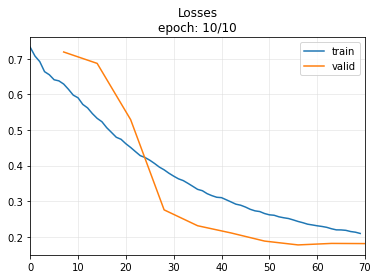

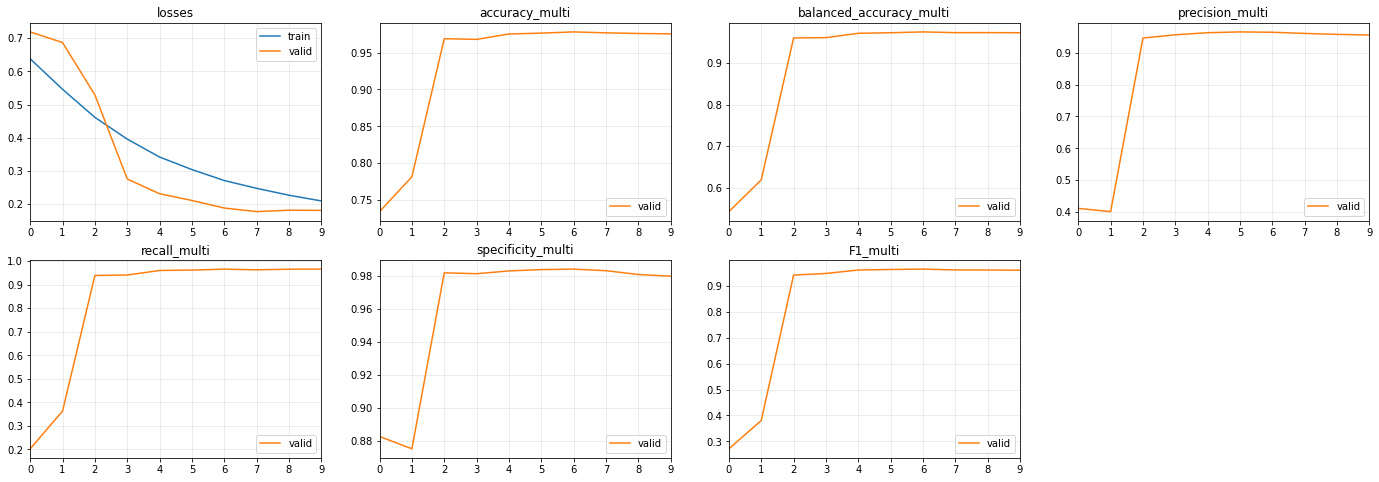

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-3)

Let's save the learner for inference: 

In [ ]:
PATH = Path('./models/Multilabel.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

### Create predictions 🌦

To get predictions we need to create a learner object from the saved file: 

In [ ]:
PATH = Path('./models/Multilabel.pkl')
learn_gpu = load_learner(PATH, cpu=False)

We can now generate predictions using just the X as input. This can be done with a 'gpu' or a 'cpu'. And for many samples, or just one at a time: 

In [ ]:
# gpu, many samples, multilabel
probas, _, preds = learn_gpu.get_X_preds(X[splits[1]])
preds[-10:]

(#10) [['Pre', 'RoT'],['Pre', 'SPC'],['Pre', 'RoT'],['Pre', 'SPC'],['Pre', 'SPC'],['Pre', 'RoT'],['Pre', 'SPC'],['Pre', 'RoT'],['Pre', 'RoT'],['Pre', 'SPC']]

In [ ]:
PATH = Path('./models/Multilabel.pkl')
learn_cpu = load_learner(PATH, cpu=True)

In [ ]:
# cpu, single sample
probas, _, preds = learn_cpu.get_X_preds(X[-1])
preds

(#1) [['Pre', 'SPC']]

### Summary of Key Points: Multi-Label Classification

#### Basic Data Preparation
- Replace earlier ```tfms  = [None, TSClassification()]```  with ```tfms  = [None, TSMultiLabelClassification()]```

#### Basic Learner

- You can build a learnr using ```learn = ts_learner()``` or  ```learn = Learner()```
- If you choose ```ts_learner``` you can pass an architecture (rather than passing pre-created model) or leave it as None, in which case the default (InceptiontimePlus) will be used.
- Use ```metrics=accuracy_multi``` in place of ```metrics=accuracy``` used in earlier multi-class example
- If no loss_func is passed, `ttsai` will set it to loss function ```loss_func=BCEWithLogitsLossFlat()```.
  
#### Multi-Label Metrics
- Remember you can use accuracy_multi(by_sample=True) which will consider as correct samples where all labels are correct. If by_sample=False, all labels for all samples will be considered, which may lead to a biased result.
- Consider using multi=label metrics, such as those included in this example.

#### Optionally Include Positive Weights with Loss Function
- Since large number of negative targets after application of binary encoding, label weighting may better optimize loss function for positive labels
- `tsai` automatically calculates multi class weights. 
- Remember to use the ones in the train set: dls.train.cws
- Include weights with loss function: ```BCEWithLogitsLossFlat(pos_weight=dls.train.cws)```
  - Weights must be in tensor form and placed on GPU (done by default is used dls.train.cws)
  - Strict weighting by False/True ratio may yield sub-optimal results.  Consider reduced weights: ```BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt())```